<h1 div class='alert alert-success'><center> Tunning Hyperparameters Rede Neural

 </center></h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

# <div class="alert alert-success">  1. IMPORTAÇÕES </div>

## 1.1. Instalações

In [1]:
!pip install --quiet optuna
!pip install --q GPUtil
#!pip install --q category_encoders

     |████████████████████████████████| 308 kB 9.0 MB/s 
     |████████████████████████████████| 209 kB 64.7 MB/s 
     |████████████████████████████████| 80 kB 12.0 MB/s 
     |████████████████████████████████| 75 kB 5.5 MB/s 
     |████████████████████████████████| 149 kB 97.2 MB/s 
     |████████████████████████████████| 112 kB 82.4 MB/s 
     |████████████████████████████████| 49 kB 7.4 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2. Bibliotecas

In [3]:
import warnings
import os
import gc
import random
import glob
import optuna
import time
import torch

In [4]:
import pandas               as pd
import numpy                as np
import matplotlib.pyplot    as plt 
import seaborn              as sns
import joblib               as jb

In [5]:
from sklearn                       import metrics
from sklearn.model_selection       import train_test_split, KFold, StratifiedKFold 
from sklearn.preprocessing         import QuantileTransformer,  KBinsDiscretizer
from sklearn.preprocessing         import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.pipeline              import make_pipeline
from sklearn.compose               import make_column_transformer

In [6]:
from optuna.samplers               import TPESampler
from optuna.visualization          import plot_edf
from optuna.visualization          import plot_optimization_history
from optuna.visualization          import plot_parallel_coordinate
from optuna.visualization          import plot_param_importances
from optuna.visualization          import plot_slice
from optuna.visualization          import plot_intermediate_values
from optuna.visualization          import plot_contour
from optuna.pruners                import MedianPruner

In [7]:
from GPUtil                        import showUtilization as gpu_usage
from psutil                        import virtual_memory
from datetime                      import datetime

In [8]:
import tensorflow as tf

In [9]:
from tensorflow                    import keras
from tensorflow.keras              import layers
from tensorflow.keras              import callbacks

## 1.3. Funções

In [10]:
def jupyter_setting():
    
    %matplotlib inline
     
    pd.options.display.max_columns = None
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
      
    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    #pd.set_option('display.max_rows', 150)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    return icecream

icecream = jupyter_setting()

In [11]:
#@title
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.rcParams['font.size'] = 12
    plt.title('Precision Recall vs threshold')
    plt.xlabel('Threshold')
    plt.legend(loc="lower left")
    
    plt.grid(True)

In [12]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b-", label="Precision")
    
    plt.rcParams['font.size'] = 12
    plt.title('Precision vs recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # plt.legend(loc="lower left")
    
    plt.grid(True)

In [13]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for TPS 09')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

In [48]:
def graf_corr(df):
    
    df = df.corr().round(5)

    # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True

    # Making a plot
    plt.figure(figsize=(16,16))
    ax = sns.heatmap(df, annot=True, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})

    ax.set_title("Mapa de calor de correlação das variável", fontsize=17)

    plt.setp(ax.get_xticklabels(), 
             rotation      = 90, 
             ha            = "right",
             rotation_mode = "anchor", 
             weight        = "normal")

    plt.setp(ax.get_yticklabels(), 
             weight        = "normal",
             rotation_mode = "anchor", 
             rotation      = 0, 
             ha            = "right");

In [49]:
def correlation(dataset, threshold):

    col_corr    = set()  # Conjunto de todos os nomes de colunas correlacionadas
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold: # estamos interessados no valor coeficiente absoluto
                colname = corr_matrix.columns[i]        # obtendo o nome da coluna
                col_corr.add(colname)
    
    return col_corr

In [50]:
def free_gpu_cache():
    
    # https://www.kaggle.com/getting-started/140636
    #print("Initial GPU Usage")
    #gpu_usage()                             

    #cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)   
    
    gc.collect()
    torch.cuda.empty_cache()

In [176]:
def seedAll(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    #random.seed(seed)    
    os.environ["PYTHONHASHSEED"] = str(seed)

seed = 12342
seedAll(seed)

## 1.4. GPU

### 1.4.1. Informações

In [52]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 24 00:26:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |   5291MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1.4.2. Memória

In [53]:
ram_gb = virtual_memory().total / 1e9

print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## 1.5. Carregar Dados

In [54]:
path = '/content/drive/MyDrive/kaggle/Tabular Playground Series/2021/11 - Novembro/'
#path = ''

In [55]:
df3_train     = jb.load(path + 'Data/pkl/df2_nb_02_train.pkl.z')
df3_test      = jb.load(path + 'Data/pkl/df2_nb_02_test.pkl.z')
df_submission = pd.read_csv(path + 'Data/sample_submission.csv')

df3_train.shape, df3_test.shape, df_submission.shape

((600000, 111), (540000, 110), (540000, 2))

In [56]:
df3_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target,fe_cluster_0,fe_cluster_1,fe_cluster_2,fe_cluster_3,fe_cluster_4,fe_mean,fe_median,fe_min,fe_max,fe_skew
0,0.106628,3.593750,132.7500,3.183594,0.081970,1.188477,3.732422,2.265625,2.099609,0.012329,1.607422,-0.318115,0.560059,2.806641,1.351562,2.535156,0.197510,0.676270,1.990234,-3.841797,0.037384,0.230347,3.330078,0.009399,0.144775,3.050781,1.303711,0.033234,-0.018280,2.748047,-0.009293,-0.036285,-0.049866,0.019485,3.898438,11.289062,1.137695,3.367188,4.945312,-0.105774,2.113281,3.453125,0.789551,1.113281,1.491211,2.439453,0.041809,3.355469,0.053680,1.701172,0.908691,0.094910,0.030212,0.597168,4.445312,1.586914,-0.068665,-0.108276,0.061035,0.046112,0.017105,-0.027557,0.019485,-0.048828,0.050751,3.728516,5.015625,4.187500,0.063354,0.121033,1.372070,4.015625,0.167603,0.039764,2.042969,-0.016617,0.107666,3.507812,0.013657,-0.097046,5.394531,0.244507,3.492188,0.113098,-0.015472,4.207031,4.105469,0.037231,-0.118835,0.067078,0.010742,1.098633,0.013329,-0.011719,0.052765,0.065430,4.210938,1.978516,0.085999,0.240479,0,1,0,0,0,0,2.650391,0.242432,-3.841797,132.7500,9.687500
1,0.125000,1.673828,76.5625,3.378906,0.099426,5.093750,1.275391,-0.471436,4.546875,0.037720,0.331787,0.325195,0.062042,2.261719,4.339844,-0.224976,0.233643,3.380859,1.903320,0.067871,-0.051270,0.006134,2.603516,0.103455,0.067627,4.753906,1.855469,-0.181885,0.008362,3.166016,0.011848,0.022293,0.069336,0.117126,0.315186,24.484375,1.671875,-0.409180,4.953125,0.092346,2.603516,1.955078,0.005898,3.289062,2.564453,0.817871,0.026001,4.617188,1.575195,0.066101,0.681641,0.025253,0.183472,0.110046,2.746094,0.835449,0.188232,4.960938,0.136108,-0.008492,-0.015266,-0.010841,0.064575,0.102539,0.093628,0.963867,0.630371,4.308594,0.091309,-0.036346,3.617188,3.103516,0.000657,0.051300,1.924805,0.123291,-0.022675,1.547852,-0.010399,0.058319,3.662109,-0.118408,2.357422,-0.009109,0.178711,4.097656,3.533203,0.005245,0.121399,0.109985,0.135864,3.460938,0.017059,0.124878,0.154053,0.606934,-0.267822,2.578125,-0.020874,0.024719,0,1,0,0,0,0,2.136719,0.145020,-0.471436,76.5625,8.429688
2,0.036316,1.497070,233.5000,2.195312,0.026917,3.126953,5.058594,3.849609,1.801758,0.057007,0.328613,2.968750,0.105225,2.070312,5.308594,1.354492,-0.261963,1.378906,1.480469,0.020538,-0.008804,0.109375,1.683594,0.038177,0.123718,1.112305,3.572266,0.120605,0.082092,2.234375,0.002270,0.045197,0.014404,0.011597,-0.502930,33.750000,1.417969,1.071289,3.222656,2.121094,3.082031,0.637695,-0.006821,-0.390869,17.343750,3.701172,-0.033600,1.578125,0.051971,-0.002005,2.691406,0.018372,-0.030472,0.111389,2.187500,-0.324951,-0.019943,3.455078,0.068115,-0.009811,-0.010628,0.027573,-0.007122,-0.048920,-0.002575,1.865234,2.404297,0.411621,0.057739,0.525391,2.167969,0.828125,0.089844,0.093750,4.949219,-0.010979,0.076660,0.266846,0.038696,0.382812,3.847656,-0.121460,3.740234,0.147095,-0.016571,0.614746,2.125000,0.078857,0.979980,0.026764,0.117310,4.882812,0.085205,0.032410,0.116089,-0.001689,-0.520020,2.140625,0.124451,0.148193,0,0,0,0,0,1,3.814453,0.124084,-0.520020,233.5000,9.609375
3,-0.014076,0.245972,780.0000,1.890625,0.006947,1.531250,2.697266,4.515625,4.503906,0.123474,1.002930,4.871094,0.058411,2.498047,1.238281,2.347656,0.175415,1.609375,2.029297,0.042084,0.005142,0.076477,1.651367,0.111816,0.121643,0.589355,4.238281,-0.032837,0.058167,0.712891,0.097473,0.072754,0.000324,0.063354,4.062500,25.375000,0.576660,2.025391,2.968750,1.085938,1.710938,1.372070,0.034637,0.722656,71.437500,3.035156,0.092224,3.453125,0.044830,0.027191,4.082031,0.046967,0.063721,0.029221,0.671875,0.185303,0.164307,3.804688,0.062317,-0.021408,0.009468,0.110901

In [57]:
df3_test.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,fe_cluster_0,fe_cluster_1,fe_cluster_2,fe_cluster_3,fe_cluster_4,fe_mean,fe_median,fe_min,fe_max,fe_skew
0,0.003229,4.839844,585.5000,2.283203,0.713379,3.908203,0.480713,1.482422,4.890625,0.056335,4.199219,3.152344,0.000349,1.851562,2.638672,0.746582,-0.004757,1.610352,4.113281,-0.077759,0.129395,0.053314,0.416748,0.445068,0.150513,5.019531,2.220703,-0.072327,-0.215820,1.562500,0.074890,0.010048,0.018585,0.067444,5.578125,3.085938,3.841797,0.011124,2.359375,0.695312,-0.345703,4.386719,0.054932,2.802734,3.873047,3.974609,0.157837,0.704590,-0.001125,-0.004547,1.010742,0.094482,0.016937,0.100891,4.367188,1.832031,0.019684,1.963867,0.120605,0.080261,0.027512,0.048828,0.074646,0.041260,0.069336,4.250000,2.091797,0.694824,0.007465,-0.017883,1.883789,1.267578,0.023743,0.043060,3.173828,0.074341,0.125854,3.925781,0.046906,-0.042297,3.019531,0.089539,3.201172,0.009682,-0.099670,3.572266,4.796875,0.091980,0.773438,0.073364,0.112915,1.073242,0.122131,0.086304,0.036011,0.010620,0.290283,1.898438,0.131592,0.012047,1,0,0,0,0,7.078125,0.154175,-0.345703,585.500000,9.992188
1,0.008598,0.505371,-100.1250,3.011719,0.027206,1.194336,5.035156,2.517578,4.554688,0.063904,0.337158,4.441406,0.013191,3.378906,3.384766,1.166992,2.246094,1.750000,2.765625,-0.058502,0.012596,0.036133,0.769043,0.017502,0.050293,0.324707,4.949219,0.124817,0.347168,1.245117,0.035828,-0.013191,0.023193,0.006443,4.984375,23.703125,8.289062,4.796875,1.798828,-0.050049,1.973633,1.912109,0.035980,2.572266,6.320312,0.442627,0.148071,1.311523,0.106689,0.625977,2.310547,-0.044342,0.194336,0.131470,4.265625,0.715820,0.017120,2.839844,0.104736,-0.007950,0.067627,0.066467,0.034271,0.605957,0.019989,-0.456787,3.378906,1.900391,0.052307,-0.050385,2.613281,3.113281,0.022308,0.108337,4.617188,0.091431,0.039368,3.035156,1.023438,-0.020584,2.771484,3.308594,5.058594,-0.003994,0.067627,0.995605,2.470703,-0.015213,0.263428,-0.021912,-0.020218,2.623047,0.123291,0.033051,0.123047,0.005772,-0.392822,3.689453,0.047424,0.119995,0,0,1,0,0,0.551270,0.293945,-100.125000,23.703125,-8.796875
2,1.460938,2.437500,-112.9375,3.541016,0.752441,4.339844,1.648438,4.699219,1.950195,0.005302,2.072266,0.546387,0.141724,1.672852,4.304688,1.702148,-0.062866,1.619141,4.191406,0.055145,-0.016586,0.017807,3.064453,0.070374,0.098328,3.507812,1.069336,0.012749,0.009979,3.468750,0.035919,-0.009804,0.065735,-0.004726,5.281250,11.531250,0.171753,4.394531,2.521484,0.079346,5.453125,1.786133,0.029617,3.064453,5.277344,0.315918,0.148315,0.463135,-0.039948,0.150635,3.753906,0.024170,0.107483,0.048737,3.582031,0.966309,-0.058960,1.870117,0.029877,-0.044281,0.065186,-0.003328,-0.001950,0.095032,0.080261,3.337891,3.605469,4.695312,0.075623,-0.088257,1.772461,-0.142212,0.000918,0.021484,0.241821,0.067566,-0.026566,0.895020,0.111633,0.524414,1.450195,0.019348,1.271484,0.076050,0.447021,4.406250,2.447266,-0.041168,0.212402,0.140991,-0.011032,2.029297,-0.000426,0.084106,0.123596,0.499512,4.054688,3.330078,0.108826,0.064697,0,1,0,0,0,0.224365,0.192139,-112.937500,11.531250,-9.570312
3,0.140503,3.085938,179.5000,0.573730,0.057343,2.216797,1.623047,0.526367,1.542969,-0.026154,1.609375,1.723633,-0.019562,1.551758,4.832031,1.501953,0.192627,4.613281,1.470703,-0.010033,0.072815,0.048035,3.230469,-0.031555,0.028702,3.751953,4.949219,-0.174561,-0.033478,2.478516,0.068115,0.090820,0.029877,0.146729,3.169922,-12.984375,3.134766,1.764648,3.253906,0.713379,3.730469,2.652344,0.080933,1.056641,1.452148,1.814453,0.077881,2.720703,0.004532,0.108826,2.833984,0.024643,-0.051422,0.060577,3.419922,1.283203,-0.083191,0.048828,-0.002502,0.051392,0.075806,-0.008904,0.1417

# <div class="alert alert-success"> 2. Split Train/Test </div>

In [58]:
X      = df3_train.drop(['target'], axis=1)    
y      = df3_train["target"].copy()
X_test = df3_test

del df3_train , df3_test

free_gpu_cache()   

# <div class="alert alert-success"> 3.  TUNNING </div>

## 3.1. Classe Tunning 

### 3.1.1. Pipeline de transformações

In [94]:
feature_int      = X_test.filter(regex=r'f[0-9]').columns.to_list()
feature_cluster  = X_test.filter(regex=r'fe_clu').columns.to_list()
feature_static   = X_test.filter(regex=r'fe_[m-s]').columns.to_list()
feature_pipeline = make_pipeline(StandardScaler(),MinMaxScaler(feature_range=(0, 1)))

preprocessor = make_column_transformer((feature_pipeline, feature_int), 
                                       (feature_pipeline, feature_cluster), 
                                       (feature_pipeline, feature_static),
                                       n_jobs=-1
                                      )

#xx = preprocessor.fit_transform(X.head(300))
#pd.DataFrame(xx).head()

In [102]:
def load_model(learning_rate_, activation_, input_shape_, dropout_=0):
    
    early_stopping = callbacks.EarlyStopping(patience             = 20,
                                             min_delta            = 0,
                                             monitor              = 'val_loss',
                                             restore_best_weights = True,
                                             verbose              = 0,
                                             mode                 = 'min', 
                                             baseline             = None,)
    
    plateau = callbacks.ReduceLROnPlateau(monitor  = 'val_loss', 
                                          factor   = 0.2, 
                                          patience = 7, 
                                          verbose  = 0,
                                          mode     = 'min')
    
    # -----------------------------------------------------------------
    # Model 
    # https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
    # https://www.kaggle.com/ryanholbrook/stochastic-gradient-descent
    # https://www.kaggle.com/sfktrkl/tps-nov-2021-nn-2 
    

    model = keras.Sequential([layers.Dense(input_shape_*2, activation = activation_, input_shape = [input_shape_]),      
                              layers.Dense(64, activation =activation_), 
                              #layers.BatchNormalization(),
                              layers.Dropout(dropout_),
                              layers.Dense(32, activation =activation_),
                              layers.Dense(16, activation =activation_),
                              layers.Dense(1, activation='sigmoid'),
                              ])
    
    # -----------------------------------------------------------------

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate_),
                  loss      = 'binary_crossentropy',
                  metrics   = ['AUC'],
                  )
    
    return model, early_stopping, plateau

In [1]:
64*2

128

In [156]:
class TunningModels():
    
    def __init__(self, name_model_, X_trn_, y_trn_, X_ts_, feature_=None, seed_=12359, path_=''):
        
        super(TunningModels,self).__init__() 

        self.name_clf         = name_model_
        self.X_trn            = X_trn_
        self.y_trn            = y_trn_
        self.X_ts             = X_ts_         
        self.feature          = feature_
        self.seed             = seed_
        self.path             = path_
        
    def diff(t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
        
    def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):
                        os.remove(os.path.join(raiz, arquivo))
        
    def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_,
                     score_, seed_, level_='1', target_='target'):

        level_ = 'n'+ level_ + '/'

        if score_>.6:          

            path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_)
            path_name_train = path_ + 'model/preds/train/' + level_ + model_name_.format(score_, seed_)
            path_name_test  = path_ + 'model/preds/test/'  + level_ + model_name_.format(score_, seed_)    
            path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)    

            jb.dump(y_pred_train_prob_, path_name_train)
            jb.dump(y_pred_test_prob_, path_name_test)
            #jb.dump(model_, path_name_model)
            #jb.dump(pd.DataFrame([model_.get_params()]), path_name_param)   

            if score_>.6:
                # Gerar o arquivo de submissão 
                df_submission[target_] = y_pred_test_prob_
                name_file_sub =  path_ + 'Data/submission/tunning/' + model_name_.format(score_, seed_) + '.csv'
                df_submission.to_csv(name_file_sub, index = False)

    def preprocessor(X_trn_, X_val_, X_tst_): 
        sc_1 = StandardScaler()
        sc_2 = MinMaxScaler(feature_range=(0, 1))

        X_trn = sc_1.fit_transform(X_trn_)
        X_val = sc_1.transform(X_val_)
        X_tst = sc_1.transform(X_tst_)

        X_trn = sc_2.fit_transform(X_trn_)
        X_val = sc_2.transform(X_val_)
        X_tst = sc_2.transform(X_tst_)

        return X_trn, X_val, X_tst
    
    def cross_valid(model_name_, X_train_, y_train_, X_test_, epochs_, learning_rate_, batch_size_, 
                    activation_, fold_, target_, path_, level_, save_predict_, print_result_, seed_,
                    dropout_=0, feature_=None):

        if feature_!=None: 
            X_train_ = X_train_[feature_]
            X_test_  = X_test_[feature_]
                    
        #--------------------------------------------------------  
        # Scorpo de variáveis
        #--------------------------------------------------------

        time_pred_start    = datetime.now()
        clf_name           = 'Rede Neural TensorFlow'
        preds_valid_f      = {}
        preds_test         = []
        total_auc          = []
        f_scores           = []
        auc_mean           = []
        f1_mean            = []
        lloss_mean         = []
        preds_test_prob    = 0    
        df_score_history   = pd.DataFrame()
        df_train_pred_fold = pd.DataFrame()
        random             = str(np.random.rand(1)[0]).replace('.','')
        model_name_        = model_name_ + '_score_{:2.5f}_{}_' + random + '.pkl.z'
        pri_result         = 95

        #--------------------------------------------------------  
        # Início do process de varilidação
        #--------------------------------------------------------
        is_dropout=''

        if dropout_>0: 
            is_dropout='*'

        if print_result_:
            msg = 'Training model: {} - seed {} - Epoch: {} - lr: {} {}'
            print('='*pri_result)            
            print(msg.format(clf_name, seed_, epochs_, learning_rate_, is_dropout))
            print('='*pri_result)

        kf = StratifiedKFold(n_splits=fold_, random_state=seed, shuffle=True)

        for fold,(idx_train, idx_val) in enumerate(kf.split(X_train_, y_train_, groups=y_train_)):

            time_fold_start = datetime.now()

            #--------------------------------------------------------  
            # Seleção dos dados
            #--------------------------------------------------------
            X_trn, X_val = X_train_.iloc[idx_train], X_train_.iloc[idx_val]
            y_trn, y_val = y_train_.iloc[idx_train], y_train_.iloc[idx_val]
            index_valid  = X_val.index.tolist() 

            #--------------------------------------------------------  
            # Processamento
            #--------------------------------------------------------
            X_trn = preprocessor.fit_transform(X_trn)
            X_val = preprocessor.transform(X_val)    
            X_tst = preprocessor.transform(X_test_.copy())               
            #X_trn, X_val, X_tst= TunningModels.preprocessor(X_trn, X_val, X_test_.copy())
            
            #--------------------------------------------------------  
            # Modelo
            #--------------------------------------------------------
            model, early_stopping, plateau = load_model(learning_rate_,
                                                        activation_, 
                                                        X_trn.shape[1], 
                                                        dropout_
                                                        )

            history = model.fit(X_trn, 
                                y_trn,
                                validation_data = (X_val, y_val),
                                batch_size      = batch_size_, 
                                epochs          = epochs_,
                                callbacks       = [early_stopping, plateau],
                                shuffle         = True,
                                verbose         = 0
                                )

            #--------------------------------------------------------  
            # oof
            #--------------------------------------------------------
            preds_valid = model.predict(X_val).reshape(1,-1)[0] 
            y_pred      = (preds_valid>.5).astype(int)

            #--------------------------------------------------------  
            # Obtenha os valores médios de cada fold para a previsão
            #--------------------------------------------------------
            #preds_test_prob.append(model.predict(X_test_).reshape(1,-1)[0])
            preds_test_prob += model.predict(X_tst).reshape(1,-1)[0] / fold_
            
            #--------------------------------------------------------  
            # Salvar score de treinamento em um DataFrame 
            #--------------------------------------------------------
            df_scores_fold          = pd.DataFrame(history.history)
            df_scores_fold['folds'] = fold     
            df_score_history        = pd.concat([df_score_history, df_scores_fold], axis=0)

            #--------------------------------------------------------  
            # Concatenar validação e predição
            #--------------------------------------------------------        
            df_val_pred_fold = pd.DataFrame({'fold'     : fold+1,
                                             'index'    : index_valid, 
                                             'pred_val' : preds_valid, 
                                             'target'   : y_val})

            df_train_pred_fold = pd.concat([df_train_pred_fold, df_val_pred_fold], axis=0)

            #--------------------------------------------------------  
            # Métricas 
            #--------------------------------------------------------
            auc   = metrics.roc_auc_score(y_val, y_pred)
            f1    = metrics.f1_score(y_val, y_pred)
            lloss = metrics.log_loss(y_val, preds_valid)   

            auc_mean.append(auc)   
            f1_mean.append(f1)    
            lloss_mean.append(lloss) 

            msg = 'Fold: {} - AUC: {:2.5f} - F1-score: {:2.5f} - L.Loss: {:2.5f} - {}'

            #--------------------------------------------------------  
            # Print resultado Fold
            #--------------------------------------------------------
            time_fold_start_end = TunningModels.diff(time_fold_start, datetime.now())
            print(msg.format(fold+1, auc, f1, lloss, time_fold_start_end))

        #del X_trn, y_trn, X_val, y_val

        df_train_pred_fold.sort_values("index", axis=0, ascending=True, inplace=True)

        #--------------------------------------------------------  
        # Salvar predição em disco
        #--------------------------------------------------------
        X_train_prob      = df_train_pred_fold['pred_val'].to_list()
        score             = np.mean(auc_mean)
        y_pred_test_prob_ = preds_test_prob # np.mean(preds_test_prob, axis=0)

        if save_predict_:
            TunningModels.save_data_model(model_             = model, 
                                          model_name_        = model_name_, 
                                          path_              = path_, 
                                          y_pred_train_prob_ = X_train_prob, 
                                          y_pred_test_prob_  = y_pred_test_prob_, 
                                          score_             = score, 
                                          seed_              = seed_, 
                                          level_             = level_, 
                                          target_            = target_
                                          )  

        #--------------------------------------------------------  
        # Print média dos Folds
        #--------------------------------------------------------
        time_pred_end = TunningModels.diff(time_pred_start, datetime.now())

        if print_result_:
            msg = '[Mean Fold]  AUC: {:.5f}(Std:{:.5f}) - F1: {:.5f} - L. Loss: {:.5f}  {}'        
            print('-'*pri_result)            
            print(msg.format(np.mean(auc_mean),np.std(auc_mean) , np.mean(f1_mean), np.mean(lloss_mean), time_pred_end))
            print('='*pri_result)
            print()

        return model, score, y_pred_test_prob_, df_score_history, df_train_pred_fold
    
    def nn(self, trial):
        
        params = {'epochs'        : trial.suggest_int('epochs', 600, 1200), 
                  'learning_rate' : trial.suggest_float ('learning_rate', 0.0001, 0.0006 ), 
                  'batch_size'    : trial.suggest_int('batch_size', 2048, 4096),
                  'activation'    : trial.suggest_categorical('activation', ['swish', 'relu']),     
                  'dropout'       : trial.suggest_float('dropout', .0, .5)        
                 }
        
        if params.get('dropout') < .2:
            params.update({'dropout': trial.suggest_float('dropout', .0)})
                    
        _, score, _, _, _ = TunningModels.cross_valid(model_name_    = self.name_clf,
                                                      X_train_       = self.X_trn,
                                                      y_train_       = self.y_trn,
                                                      X_test_        = self.X_ts,
                                                      epochs_        = params.get('epochs'),
                                                      learning_rate_ = params.get('learning_rate'),
                                                      batch_size_    = params.get('batch_size'),
                                                      activation_    = params.get('activation'),
                                                      fold_          = 5,
                                                      target_        ='target',
                                                      path_          = self.path,
                                                      level_         = '1',
                                                      save_predict_  = True,
                                                      print_result_  = True,
                                                      seed_          = self.seed, 
                                                      dropout_       = params.get('dropout')
                                                      )        
        
        print('param = {}'.format(params))
        print()

        return score    

In [104]:
my_seed = seed
def seedAll(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seedAll(my_seed)

In [105]:
# Some parameters to config  https://www.kaggle.com/adityasharma01/simple-nn-tps-nov-21
EPOCHS        = 840
BATCH_SIZE    = 2048 * 2
ACTIVATION    = 'swish'
LEARNING_RATE = 0.000265713
FOLDS         = 5
name_model_clf = 'rnn_' 
name_model     = name_model_clf + '01_tunning_' 

feature_int      = X_test.filter(regex=r'f[0-9]').columns.to_list()
feature_cluster  = X_test.filter(regex=r'fe_clu').columns.to_list()
feature_static   = X_test.filter(regex=r'fe_[m-s]').columns.to_list()
feature_pipeline = make_pipeline(StandardScaler(),MinMaxScaler(feature_range=(0, 1)))

preprocessor = make_column_transformer((feature_pipeline, feature_int), 
                                       (feature_pipeline, feature_cluster), 
                                       (feature_pipeline, feature_static),
                                       n_jobs=-1
                                      )

model, score, y_pred_test, df_score_history, _ = TunningModels.cross_valid(model_name_    = name_model,
                                                            X_train_       = X,
                                                            y_train_       = y,
                                                            X_test_        = X_test,
                                                            feature_       = None,
                                                            epochs_        = EPOCHS,
                                                            learning_rate_ = LEARNING_RATE,
                                                            batch_size_    = BATCH_SIZE,
                                                            activation_    = ACTIVATION,
                                                            fold_          = FOLDS,
                                                            target_        ='target',
                                                            path_          = path,
                                                            level_         = '1',
                                                            save_predict_  = True,
                                                            print_result_  = True,
                                                            seed_          = seed
                                                             )  

Training model: Rede Neural TensorFlow - seed 12342 - Epoch: 700 - lr: 0.0007 
Fold: 1 - AUC: 0.74676 - F1-score: 0.75106 - L.Loss: 0.56522 - 0h 1m 58s
Fold: 2 - AUC: 0.74281 - F1-score: 0.74746 - L.Loss: 0.56937 - 0h 2m 6s
Fold: 3 - AUC: 0.74263 - F1-score: 0.74755 - L.Loss: 0.56910 - 0h 2m 26s
Fold: 4 - AUC: 0.74341 - F1-score: 0.74792 - L.Loss: 0.56796 - 0h 1m 58s
Fold: 5 - AUC: 0.74184 - F1-score: 0.74703 - L.Loss: 0.56967 - 0h 2m 11s
-----------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.74349(Std:0.00171) - F1: 0.74820 - L. Loss: 0.56827  0h 10m 44s



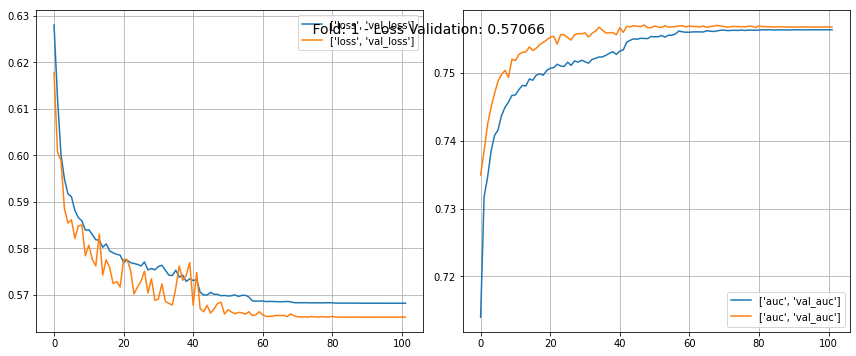

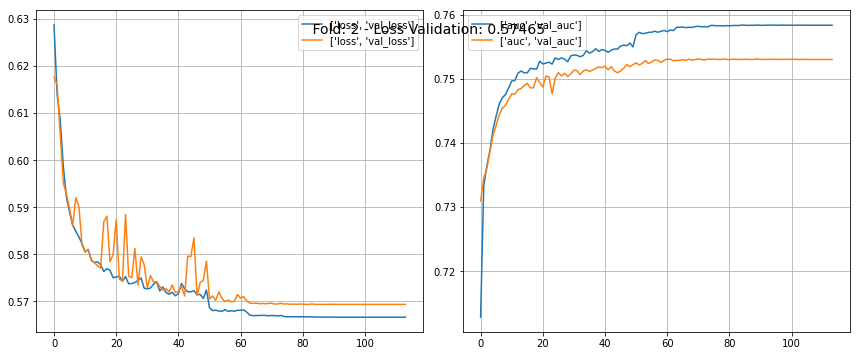

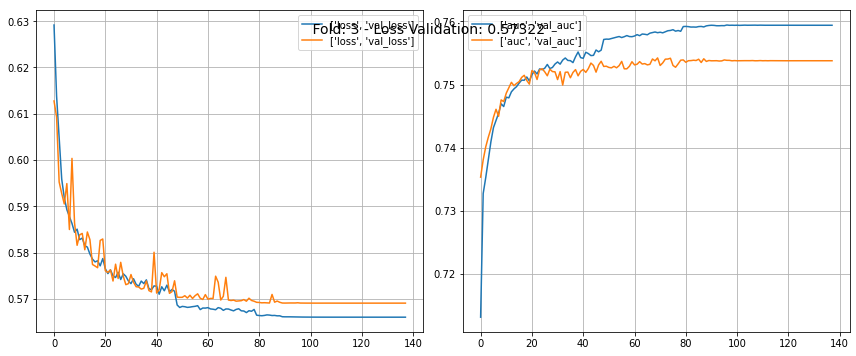

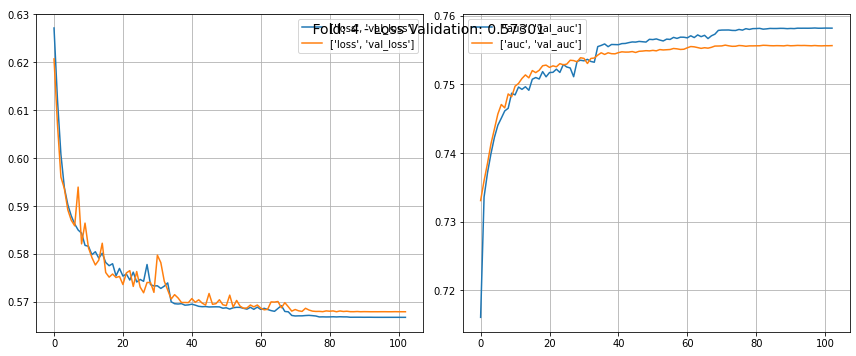

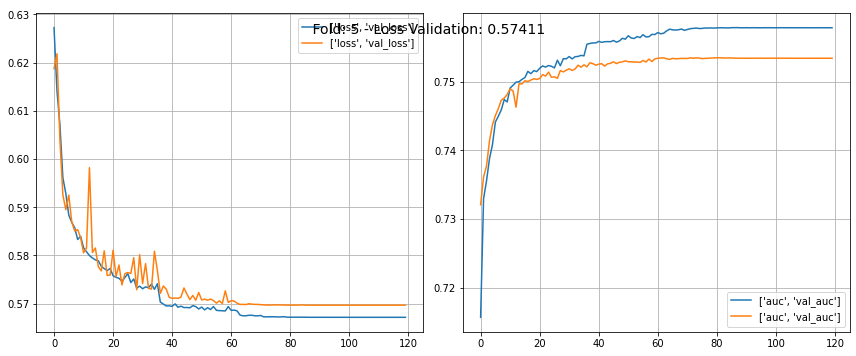

In [106]:
for fold in range(df_score_history['folds'].nunique()):

    history_f = df_score_history[df_score_history['folds'] == fold]
    
    lloss_val = history_f['val_loss'].mean()
    subtitle  = '\n Fold: {} - Loss Validation: {:2.5f} \n'.format(fold+1, lloss_val)
    
    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12,5))
    fig.suptitle(subtitle, fontsize=14)
        
    plt.subplot(1,2,1)
    plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])
    plt.legend(fontsize=10)
    plt.grid()
    
    #print("Validation Loss: {:0.4f}".format(history_f['val_loss'].min()));
    
    plt.subplot(1,2,2)  
    plt.plot(history_f.loc[:, ['auc', 'val_auc']],label= ['auc', 'val_auc'])
    plt.legend(fontsize=10)
    plt.grid()

### 3.1.2. Tunning Rede Neural

In [107]:
%%time

n_trials_  = 50
score_     = 0
name_model = 'rnn_01_tunning'

TunningModels.delete_files(name_model)

# Inicialize a classe do modelo de otimização
modelOpt = TunningModels(name_model_     = name_model, 
                         X_trn_          = X,
                         y_trn_          = y,
                         X_ts_           = X_test,                                     
                         feature_        = None, 
                         seed_           = seed, 
                         path_           = path
                        )
 
study = optuna.create_study(direction = 'maximize',
                            sampler   = optuna.samplers.TPESampler(seed=seed),
                            pruner    = optuna.pruners.MedianPruner(n_warmup_steps=10),
                            study_name= 'nn_tuning'
                            ) 

study.optimize(modelOpt.nn, n_trials=n_trials_)

score  = study.best_value 
params = study.best_params 

if score > score_ : 
    score_      = score
    seed_best   = seed
    score_best  = score 
    params_best = params
    
print()
print('-'*110)
print('Best score: {:2.5f}'.format(score_best))
print('Seed      : {}'.format(seed_best))
print('Parameters:\n\n{}'.format(params_best))
print()

Training model: Rede Neural TensorFlow - seed 12342 - Epoch: 1010 - lr: 0.0002740323666139822 
Fold: 1 - AUC: 0.74518 - F1-score: 0.74917 - L.Loss: 0.56611 - 0h 1m 39s
Fold: 2 - AUC: 0.73931 - F1-score: 0.74427 - L.Loss: 0.57192 - 0h 1m 32s
Fold: 3 - AUC: 0.73904 - F1-score: 0.74392 - L.Loss: 0.57206 - 0h 1m 35s
Fold: 4 - AUC: 0.73998 - F1-score: 0.74446 - L.Loss: 0.57103 - 0h 1m 40s
Fold: 5 - AUC: 0.73881 - F1-score: 0.74401 - L.Loss: 0.57166 - 0h 1m 35s
-----------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.74046(Std:0.00239) - F1: 0.74516 - L. Loss: 0.57055  0h 8m 7s

param = {'epochs': 1010, 'learning_rate': 0.0002740323666139822, 'batch_size': 3752, 'activation': 'relu', 'dropout': 0}

Training model: Rede Neural TensorFlow - seed 12342 - Epoch: 710 - lr: 0.00013186493580741684 *
Fold: 1 - AUC: 0.74391 - F1-score: 0.74818 - L.Loss: 0.56673 - 0h 1m 50s
Fold: 2 - AUC: 0.73803 - F1-score: 0.74263 - L.Loss: 0.57214 - 0h 1m 5

In [108]:

score  = study.best_value 
params = study.best_params 


if score > score_ : 
    score_      = score
    seed_best   = seed 
    score_best  = score 
    params_best = params
    

print() 
print('-'*110)
print('Best score: {:2.5f}'.format(score_best))
print('Seed      : {}'.format(seed_best))
print('Parameters:\n\n{}'.format(params_best))
print()


--------------------------------------------------------------------------------------------------------------
Best score: 0.74372
Seed      : 12342
Parameters:

{'epochs': 902, 'learning_rate': 0.0004678548573865923, 'batch_size': 2202, 'activation': 'swish', 'dropout': 0.07313520521472415}



In [124]:
params_best = {'epochs': 902, 'learning_rate': 0.0004678548573865923, 'batch_size': 2202, 'activation': 'swish', 'dropout': 0} 
   
score_best = 0.74372
seed_best  = 12359
   
print()
print('-'*110)
print('Best score: {:2.5f}'.format(score_best))
print('Seed      : {}'.format(seed_best))
print('Parameters:\n\n{}'.format(params_best))
print()



--------------------------------------------------------------------------------------------------------------
Best score: 0.74372
Seed      : 12359
Parameters:

{'epochs': 902, 'learning_rate': 0.0004678548573865923, 'batch_size': 2202, 'activation': 'swish', 'dropout': 0}



### Análise 

In [113]:
###################################################################################################
# Plot functions
# --------------
# Visualize the optimization history. See :func:`~optuna.visualization.plot_optimization_history` for the details.
plot_optimization_history(study)

In [ ]:
#plot_intermediate_values(study)
###################################################################################################
# Visualize the learning curves of the trials. See :func:`~optuna.visualization.plot_intermediate_values` for the details.
#plot_intermediate_values(study)

In [114]:
###################################################################################################
# Visualize high-dimensional parameter relationships. See :func:`~optuna.visualization.plot_parallel_coordinate` for the details.
plot_parallel_coordinate(study)

In [115]:
###################################################################################################
# Select parameters to visualize.
plot_parallel_coordinate(study, params=["batch_size", "epochs"])

In [ ]:
###################################################################################################
# Visualize hyperparameter relationships. See :func:`~optuna.visualization.plot_contour` for the details.
#plot_contour(study)

In [117]:
###################################################################################################
# Select parameters to visualize.
plot_contour(study, params=["batch_size", "epochs"])

In [ ]:
###################################################################################################
# Visualize individual hyperparameters as slice plot. See :func:`~optuna.visualization.plot_slice` for the details.
plot_slice(study)

In [118]:
###################################################################################################
# Select parameters to visualize.
plot_slice(study, params=["batch_size", "epochs"])

In [ ]:
###################################################################################################
# Visualize parameter importances. See :func:`~optuna.visualization.plot_param_importances` for the details.
#plot_param_importances(study)

In [ ]:
###################################################################################################
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
# optuna.visualization.plot_param_importances( study, target=lambda t: t.duration.total_seconds(), target_name="duration")

In [119]:
###################################################################################################
# Visualize empirical distribution function. See :func:`~optuna.visualization.plot_edf` for the details.
plot_edf(study)

### 1.2.3. Modelo Final
Agora que temos os melhores parametros, vamos treinar uma modelo com esse parametros e fazer algumas análises. 

In [145]:
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      stratify     = y,
                                                      random_state = 12359)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape 

((480000, 110), (480000,), (120000, 110), (120000,))

In [157]:
%%time

EPOCHS        = params_best.get('epochs')
BATCH_SIZE    = params_best.get('batch_size')
ACTIVATION    = params_best.get('activation')
LEARNING_RATE = params_best.get('learning_rate')
FOLDS         = 5
name_model_clf = 'rnn_' 
name_model     = name_model_clf + '02_tunning_' 

model, score, y_pred_test, df_score_history, _ = TunningModels.cross_valid(model_name_     = name_model,
                                                                            X_train_       = X_train,
                                                                            y_train_       = y_train,
                                                                            X_test_        = X_test,
                                                                            feature_       = None,
                                                                            epochs_        = EPOCHS,
                                                                            learning_rate_ = LEARNING_RATE,
                                                                            batch_size_    = BATCH_SIZE,
                                                                            activation_    = ACTIVATION,
                                                                            fold_          = FOLDS,
                                                                            target_        ='target',
                                                                            path_          = path,
                                                                            level_         = '1',
                                                                            save_predict_  = True,
                                                                            print_result_  = True,
                                                                            seed_          = seed
                                                                            )  

Training model: Rede Neural TensorFlow - seed 12342 - Epoch: 902 - lr: 0.0004678548573865923 
Fold: 1 - AUC: 0.74294 - F1-score: 0.74769 - L.Loss: 0.56890 - 0h 2m 2s
Fold: 2 - AUC: 0.74362 - F1-score: 0.74811 - L.Loss: 0.56912 - 0h 1m 38s
Fold: 3 - AUC: 0.74268 - F1-score: 0.74765 - L.Loss: 0.56865 - 0h 1m 53s
Fold: 4 - AUC: 0.73975 - F1-score: 0.74457 - L.Loss: 0.57323 - 0h 1m 41s
Fold: 5 - AUC: 0.74274 - F1-score: 0.74743 - L.Loss: 0.56922 - 0h 2m 2s
-----------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.74235(Std:0.00134) - F1: 0.74709 - L. Loss: 0.56983  0h 9m 21s

CPU times: user 14min 51s, sys: 2min 5s, total: 16min 57s
Wall time: 9min 21s


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Observando os dados acima do treinamento, parece que temos um AUC boa, vamos dar uma olhada no gráfico de treinamento do modelo.
    
</div>

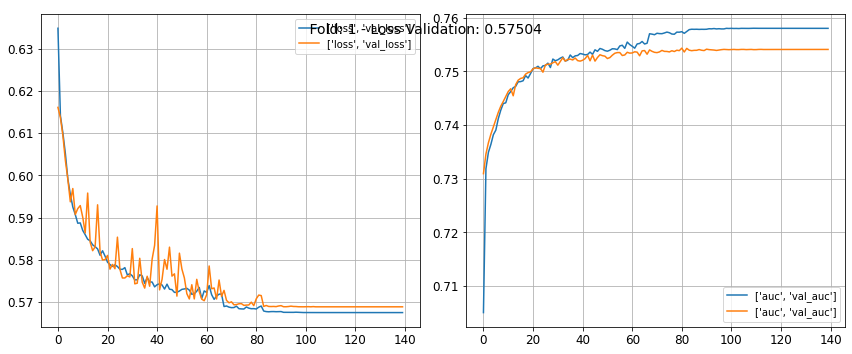

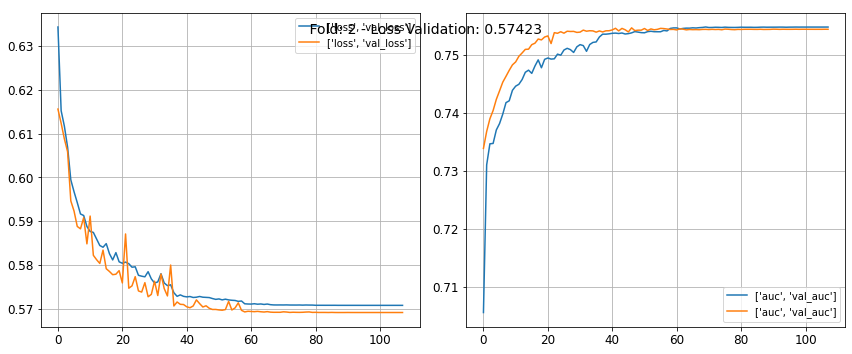

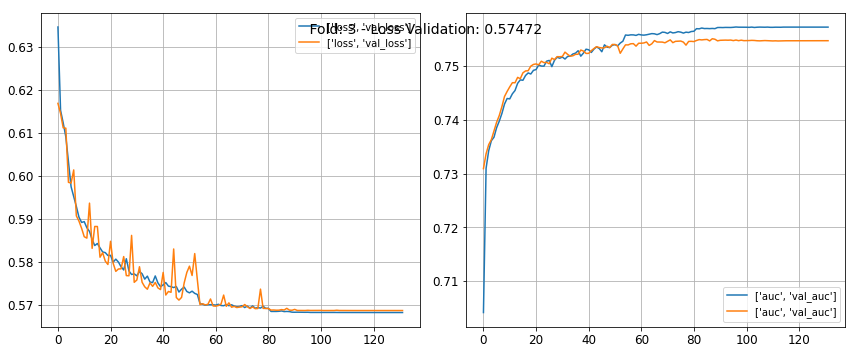

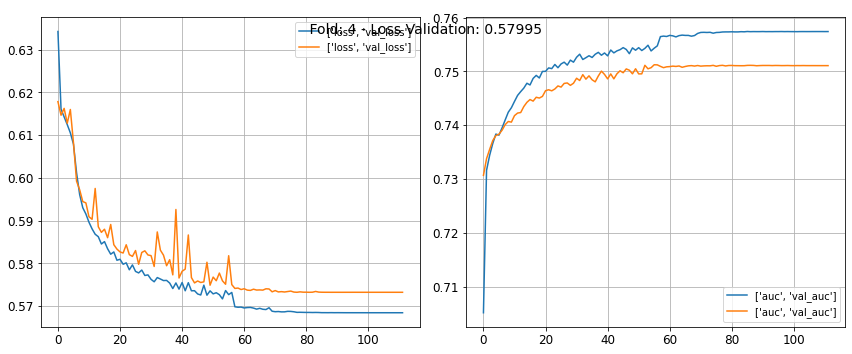

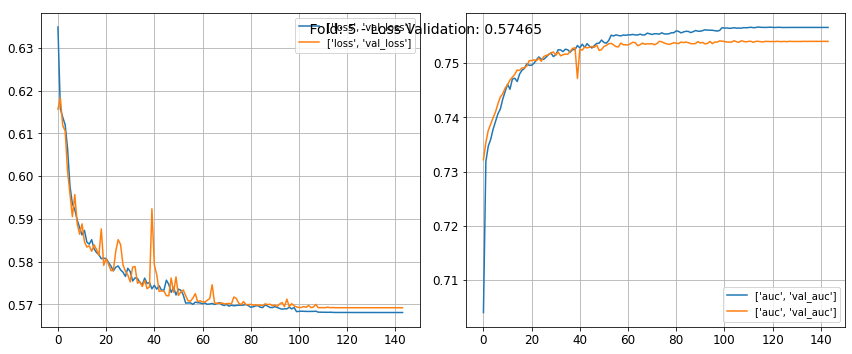

In [158]:
for fold in range(df_score_history['folds'].nunique()):

    history_f = df_score_history[df_score_history['folds'] == fold]
    
    lloss_val = history_f['val_loss'].mean()
    subtitle  = '\n Fold: {} - Loss Validation: {:2.5f} \n'.format(fold+1, lloss_val)
    
    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12,5))
    fig.suptitle(subtitle, fontsize=14)
        
    plt.subplot(1,2,1)
    plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])
    plt.legend(fontsize=10)
    plt.grid()
        
    plt.subplot(1,2,2)  
    plt.plot(history_f.loc[:, ['auc', 'val_auc']],label= ['auc', 'val_auc'])
    plt.legend(fontsize=10)
    plt.grid()

In [159]:
X_valid_scaler = preprocessor.fit_transform(X_valid)
y_hat_002 = model.predict(X_valid_scaler).reshape(1,-1)[0] 

#### 1.2.3.1. Analise do Modelo

#### 1.2.3.1.1. Curva Roc

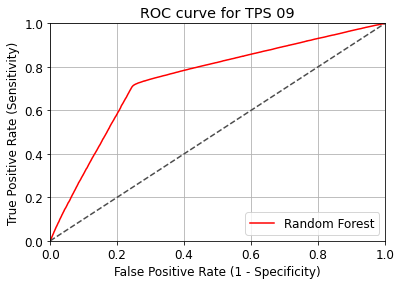

In [160]:
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_hat_002)
plot_roc_curve(fpr, tpr, label="Random Forest")
plt.show()

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
 

</div>


In [161]:
threshold = .5
f1_002  = metrics.f1_score (y_valid, (y_hat_002 > threshold))
auc_002 = metrics.roc_auc_score(y_valid, y_hat_002 )
print(metrics.classification_report(y_valid, (y_hat_002 > threshold).astype(int) ))
print('')
print('F1-score: {:2.5f}'.format(f1_002))
print('AUC     : {:2.5f}'.format(auc_002))

              precision    recall  f1-score   support

           0       0.69      0.77      0.73     59279
           1       0.75      0.66      0.70     60721

    accuracy                           0.71    120000
   macro avg       0.72      0.72      0.71    120000
weighted avg       0.72      0.71      0.71    120000


F1-score: 0.70009
AUC     : 0.74262


TypeError: ignored

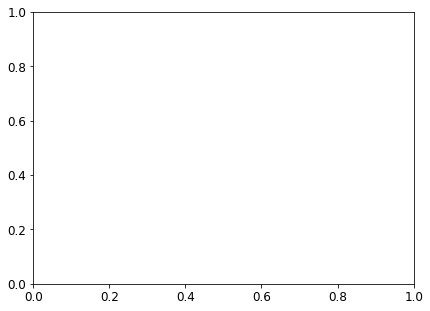

In [166]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,2,1)

metrics.plot_confusion_matrix(#model, 
                              X_valid, 
                              y_valid, 
                              #cmap          = 'inferno', 
                              #values_format = 'd', 
                              #ax            = ax
                              ) 
#true’, ‘pred’, ‘all’

plt.title('Confusion matrix')

ax= plt.subplot(1,2,2)
metrics.plot_confusion_matrix(model_002, X, y, cmap='inferno', normalize='all', ax=ax) 
plt.title('Confusion matrix');

In [ ]:
del X_train, y_train, X_valid, y_valid

### 1.2.4. Divercidade

#### 1.2.4.1. SEED
Nesta etapa vamos utilizar os melhores parametros, que encontramos na tunagem acima, com `seed` diferentes. 

In [ ]:
%%time 

SEED_         = [42, 59, 100, 200, 1000, 1500, 2020, 2021, 5000, 10000, 7000]
df_seed       = pd.DataFrame()
seed_best     = seed_best

EPOCHS        = params_best.get('epochs')
BATCH_SIZE    = params_best.get('batch_size')
ACTIVATION    = params_best.get('activation')
LEARNING_RATE = params_best.get('learning_rate')
FOLDS         = 10
name_model_clf = 'rnn_' 
name_model     = name_model_clf + '003_div_seed_' 

TunningModels.delete_files(name_model)

for i, seed_ in  enumerate (SEED_):     
        
    seedAll(seed_)
    
    model, score, y_pred_test, df_score_history, _ = TunningModels.cross_valid(model_name_     = name_model,
                                                                                X_train_       = X,
                                                                                y_train_       = y,
                                                                                X_test_        = X_test,
                                                                                feature_       = None,
                                                                                epochs_        = EPOCHS,
                                                                                learning_rate_ = LEARNING_RATE,
                                                                                batch_size_    = BATCH_SIZE,
                                                                                activation_    = ACTIVATION,
                                                                                fold_          = FOLDS,
                                                                                target_        ='target',
                                                                                path_          = path,
                                                                                level_         = '1',
                                                                                save_predict_  = True,
                                                                                print_result_  = True,
                                                                                seed_          = seed_
                                                                                )  
                
    if score > score_best:         
        seed_best  = seed_
        score_best = score

    df_seed['seed_' + str(seed_)] = y_pred_test 
   
print('Seed best: {}'.format(seed_best))
print('Score    : {:2.5f}'.format(score_best))

Training model: Rede Neural TensorFlow - seed 42 - Epoch: 902 - lr: 0.0004678548573865923 
Fold: 1 - AUC: 0.74579 - F1-score: 0.75006 - L.Loss: 0.56673 - 0h 1m 55s
Fold: 2 - AUC: 0.74743 - F1-score: 0.75128 - L.Loss: 0.56412 - 0h 2m 19s
Fold: 3 - AUC: 0.74277 - F1-score: 0.74755 - L.Loss: 0.56995 - 0h 2m 6s
Fold: 4 - AUC: 0.74218 - F1-score: 0.74670 - L.Loss: 0.57003 - 0h 2m 5s
Fold: 5 - AUC: 0.74247 - F1-score: 0.74722 - L.Loss: 0.57031 - 0h 1m 54s
Fold: 6 - AUC: 0.74299 - F1-score: 0.74796 - L.Loss: 0.56975 - 0h 2m 0s
Fold: 7 - AUC: 0.74389 - F1-score: 0.74829 - L.Loss: 0.56795 - 0h 2m 53s
Fold: 8 - AUC: 0.74215 - F1-score: 0.74662 - L.Loss: 0.57063 - 0h 2m 1s
Fold: 9 - AUC: 0.74378 - F1-score: 0.74876 - L.Loss: 0.56803 - 0h 2m 53s
Fold: 10 - AUC: 0.74035 - F1-score: 0.74593 - L.Loss: 0.57207 - 0h 2m 12s
-----------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.74338(Std:0.00190) - F1: 0.74804 - L. Loss: 0.56896  0h 22m 26s

T

In [1]:
 df_seed.head()

NameError: ignored

In [187]:
submission = pd.DataFrame({'id': df_submission.id, 'target': df_seed.mean(axis=1)})
submission.to_csv(path + 'Data/submission/rnn_003_div_seed.csv', index=False)

#### 1.2.4.1. Bath Size

In [188]:
df_bach_size  = pd.DataFrame()
seed_best     = seed_best

EPOCHS        = params_best.get('epochs')
BATCH_SIZE    = 2048
ACTIVATION    = params_best.get('activation')
LEARNING_RATE = params_best.get('learning_rate')
FOLDS         = 5
name_model_clf = 'rnn_' 
name_model     = name_model_clf + '004_div_bach_size_' 

TunningModels.delete_files(name_model)

for i, seed_ in  enumerate (range(5)):     
        
    seedAll(seed_best)
         
    model, score, y_pred_test, df_score_history, _ = TunningModels.cross_valid(model_name_     = name_model,
                                                                                X_train_       = X,
                                                                                y_train_       = y,
                                                                                X_test_        = X_test,
                                                                                feature_       = None,
                                                                                epochs_        = EPOCHS,
                                                                                learning_rate_ = LEARNING_RATE,
                                                                                batch_size_    = BATCH_SIZE,
                                                                                activation_    = ACTIVATION,
                                                                                fold_          = FOLDS,
                                                                                target_        ='target',
                                                                                path_          = path,
                                                                                level_         = '1',
                                                                                save_predict_  = True,
                                                                                print_result_  = True,
                                                                                seed_          = seed_best
                                                                                )  

    
    if score > score_best:                
        score_best     = score
        bach_size_best = BATCH_SIZE

    df_bach_size['bach_size_' + str(BATCH_SIZE)] = y_pred_test 
    
    BATCH_SIZE += 1024

print('Seed best: {}'.format(seed_best))
print('Score    : {:2.5f}'.format(score_best))
print('Bach size: {}'.format(bach_size_best))

Training model: Rede Neural TensorFlow - seed 12359 - Epoch: 902 - lr: 0.0004678548573865923 
Fold: 1 - AUC: 0.74608 - F1-score: 0.75064 - L.Loss: 0.56590 - 0h 2m 10s
Fold: 2 - AUC: 0.74151 - F1-score: 0.74611 - L.Loss: 0.57108 - 0h 1m 54s
Fold: 3 - AUC: 0.74246 - F1-score: 0.74733 - L.Loss: 0.57017 - 0h 2m 19s
Fold: 4 - AUC: 0.74367 - F1-score: 0.74811 - L.Loss: 0.56860 - 0h 2m 10s
Fold: 5 - AUC: 0.74232 - F1-score: 0.74767 - L.Loss: 0.56962 - 0h 2m 29s
-----------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.74321(Std:0.00160) - F1: 0.74797 - L. Loss: 0.56907  0h 11m 6s

Training model: Rede Neural TensorFlow - seed 12359 - Epoch: 902 - lr: 0.0004678548573865923 
Fold: 1 - AUC: 0.74555 - F1-score: 0.75001 - L.Loss: 0.56675 - 0h 1m 54s
Fold: 2 - AUC: 0.74206 - F1-score: 0.74668 - L.Loss: 0.57064 - 0h 1m 47s
Fold: 3 - AUC: 0.74255 - F1-score: 0.74741 - L.Loss: 0.57034 - 0h 2m 7s
Fold: 4 - AUC: 0.74229 - F1-score: 0.74673 - L.Lo

In [2]:
df_bach_size.head() 

NameError: ignored

In [190]:
submission = pd.DataFrame({'id': df_submission.id, 'target': df_bach_size.mean(axis=1)})
submission.to_csv(path + 'Data/submission/rnn_004_bach_size.csv', index=False)

#### 1.2.4.3. FEATURE

In [ ]:
params_best

In [ ]:
%%time

TunningModels.model_of_diversity_feature_group(model           = RandomForestClassifier(**params_best), 
                                               name_model_     = 'rf_005_div_feature_', 
                                               X_              = X, 
                                               y_              = y, 
                                               X_ts_           = X_test,
                                               scaler_         = sc,
                                               feature_bin_    = feature_int, 
                                               feature_imp_num = 3, 
                                               seed_           = seed_best) 

### 1.2.5. Ensable 

#### 1.2.5.1. Recuparar dataset
Vamos recuperar todas as previsões do LGBM para gerar um ensable. 

In [192]:
%%time 
df_train_rf, df_test_rf = TunningModels.df_return_preds_tunning('rnn')
print(df_train_rf.shape, df_test_rf.shape)
print()

AttributeError: ignored

In [ ]:
df_train_rf.head()

In [ ]:
y_pred      = df_train_rf['target']
df_train_rf = df_train_rf.filter(regex=r'_0.8' , axis=1)
df_test_rf  = df_test_rf.filter(regex=r'_0.8', axis=1)

df_train_rf['target'] = y_pred
df_train_rf.shape, df_test_rf.shape

In [ ]:
df_train_rf.head()

#### 1.2.5.2. Descritiva

In [ ]:
df_test_rf.mean(axis=1).describe()

#### 1.2.5.3. Gerar submission 
Vamos gerar uma submission com a media das previssões, para termos uma ideia de como estamos. 

In [ ]:
y_hat_rf_mean = df_test_rf.mean(axis=1)
submission = pd.DataFrame({'id': df_submission.id, 'claim': y_hat_rf_mean })
submission.to_csv(path + 'Data/sumbmission/rf_003_feature_gr.csv', index=False) 
# score kaggle: 0.60423

In [ ]:
y_hat_rf_mean

#### 1.2.5.4. Correlação

In [ ]:
graf_corr(df_train_rf)

Temos muitas previsões autocorrelacionadas, vamos fazer a exclusão de algumas.

In [ ]:
corr_features = correlation(df_train_rf, 0.9)
len(set(corr_features))

In [ ]:
#df_train_lgbm.drop(labels=corr_features, axis=1, inplace=True)

graf_corr(df_train_rf) 

In [ ]:
X_rf      = df_train_rf.drop(['claim'], axis=1)    
y_rf      = df_train_rf["claim"].copy()
X_test_rf = df_test_rf

X_train_rf, X_valid_rf, y_train_rf, y_valid_rf = train_test_split(X_rf, 
                                                                      y_rf, 
                                                                      test_size    = 0.2, 
                                                                      shuffle      = True, 
                                                                     # stratify     = y_rf,
                                                                      random_state = 12359)

print(X_train_rf.shape, y_train_rf.shape, X_valid_rf.shape, y_valid_rf.shape, X_rf.shape, 
      y_rf.shape, X_test_rf.shape) 


In [ ]:
%%time

model_rf_003      = RandomForestClassifier(**params_best_seed)
                                        
y_hat_test_rf_003 = TunningModels.cross_valid(model       = model_rf_003, 
                                               model_name_ = name_model_rf, 
                                               X_          = X_rf, 
                                               y_          = y_rf, 
                                               X_test_     = X_test_rf, 
                                               type_model  = 2, 
                                               feature     = None,
                                               seed        = SEED, 
                                               tunning     = 0
                                               )

model_rf_003 = model_rf_003.fit(X_train_rf, y_train_rf)
y_hat_rf_003 = model_rf_003.predict_proba (X_valid_rf)

# OUTROS MODELOS 

## 01 
https://www.kaggle.com/gaganmaahi224/tps-nov-21-autoviz-simple-ann-for-beginners#Feature-Selection-and-Feature-Scaling

In [ ]:
feature_int      = X_test.filter(regex=r'f[0-9]').columns.to_list()
feature_cluster  = X_test.filter(regex=r'fe_clu').columns.to_list()
feature_static   = X_test.filter(regex=r'fe_[m-s]').columns
feature_pipeline = make_pipeline(StandardScaler(),MinMaxScaler(feature_range=(0, 1)))

preprocessor = make_column_transformer((feature_pipeline, feature_int), 
                                       (feature_pipeline, feature_cluster), 
                                       (feature_pipeline, feature_static),
                                       n_jobs=-1
                                      )

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y, 
                                                      test_size    = 0.3, 
                                                      shuffle      = True, 
                                                     # stratify     = y_rf,
                                                      random_state = 12359)


#--------------------------------------------------------  
# Processamento
#--------------------------------------------------------
X_train      = preprocessor.fit_transform(X_train)
X_valid      = preprocessor.transform(X_valid)    
X_test_scale = preprocessor.transform(X_test.copy())

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()   

In [ ]:
#pip install --q pydot

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
w_p = y_train.value_counts()[0] / len(y_train)
w_n = y_train.value_counts()[1] / len(y_train)

In [ ]:
%%time 

METRICS = [
#     keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'), 
    keras.metrics.Recall(name='auc')
]

model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=METRICS)

callbacks = [keras.callbacks.ModelCheckpoint('fraud_model_at_epoch_{epoch}.h5')]
class_weight = {0:w_p, 1:w_n}

r = model.fit(X_train, 
              y_train, 
              validation_data= (X_valid, y_valid),
              batch_size     = 4048, 
              epochs         = 100,              
              callbacks      = callbacks,# [early_stopping, plateau],
              shuffle        = True,
              verbose        = 0 
              #class_weight  = class_weight,
              )

In [ ]:
def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(metrics.classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {metrics.accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {metrics.confusion_matrix(y_train, prediction)}\n")
    elif train==False:
        print()
        clf_report = pd.DataFrame(metrics.classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {metrics.accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {metrics.confusion_matrix(label, prediction)}\n") 

In [ ]:
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

In [ ]:
print_score(y_train, y_train_pred.round(), train=True)
print_score(y_valid, y_valid_pred.round(), train=False)

scores_dict = {
    'ANNs': {
        'Train': metrics.f1_score(y_train, y_train_pred.round()),
        'Test': metrics.f1_score(y_valid, y_valid_pred.round()),
    },
}


In [ ]:
auc_train = metrics.roc_auc_score(y_train, y_train_pred)
auc_valid = metrics.roc_auc_score(y_valid, y_valid_pred)

print ('AUC Train: {:2.5f}'.format(auc_train))
print ('AUC Valid: {:2.5f}'.format(auc_valid))

In [ ]:
# AUC Valid: 0.74995 => 0.74475
# AUC Valid: 0.74522 => 0.74026

In [ ]:
score = model.evaluate(X_valid, y_valid)
print(score)

In [ ]:
plt.figure(figsize=(12, 20))

plt.subplot(6, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function evolution during training')
plt.legend()

plt.subplot(6, 2, 2)
plt.plot(r.history['fn'], label='fn')
plt.plot(r.history['val_fn'], label='val_fn')
plt.title('Accuracy evolution during training')
plt.legend()

plt.subplot(6, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision evolution during training')
plt.legend()

plt.subplot(6, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall evolution during training')
plt.legend();

plt.subplot(6, 2, 5)
plt.plot(r.history['auc'], label='auc')
plt.plot(r.history['val_auc'], label='val_auc')
plt.title('Recall evolution during training')
plt.legend();

plt.subplot(6, 2, 6)
plt.plot(r.history['auc'], label='auc')
plt.plot(r.history['val_auc'], label='val_auc')
plt.title('Recall evolution during training')
plt.legend();

### Prediction on test data

In [ ]:
y_pred_test = model.predict(X_test_scale)

In [ ]:
y_pred_test

In [ ]:
array([[0.7133523 ],
       [0.70387346],
       [0.7147807 ],
       ...,
       [0.7813918 ],
       [0.7010438 ],
       [0.6736814 ]], dtype=float32)

In [ ]:
df_submission['target'] = y_pred_test

## 2

In [79]:
train = X
test  = X_test
target = y

In [28]:

# the number 2 is just a threshold to split 
h_skew = train.loc[:,train.skew() >= 2].columns  # with Skewed 
l_skew = train.loc[:,train.skew() < 2].columns   # Bimodal

In [ ]:
train['median_h'] = train.median(axis=1)
test['median_h'] = test.median(axis=1)

train['var_h'] = train.var(axis=1)
test['var_h'] = test.var(axis=1)

train['mean_l'] = train.mean(axis=1)
test['mean_l'] = test.mean(axis=1)

train['std_l'] = train.std(axis=1)
test['std_l'] = test.std(axis=1)

In [80]:
raw_train = train.copy()
raw_test = test.copy()

In [81]:
feature_int=  train.columns.to_list()
feature_pipeline = make_pipeline(StandardScaler(),MinMaxScaler(feature_range=(0, 1)))

preprocessor = make_column_transformer((feature_pipeline, feature_int),                                        
                                       n_jobs=-1
                                      )

### Neural Network

In [35]:

EPOCHS = 700
BATCH_SIZE = 2048 
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
FOLDS = 5

In [75]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

import tensorflow as tf
import random
import os

# -----------------------------------------------------------------
# Seed 

my_seed = 42
def seedAll(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seedAll(my_seed)

# -----------------------------------------------------------------

def load_model(name:str):
    
    early_stopping = callbacks.EarlyStopping(
        patience=20,
        min_delta=0,
        monitor='val_loss',
        restore_best_weights=True,
        verbose=0,
        mode='min', 
        baseline=None,
    )

    plateau = callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=7, 
            verbose=0,
            mode='min')

# -----------------------------------------------------------------
# Model 

    model = keras.Sequential([
        layers.Dense(train.shape[1]*2, activation = ACTIVATION, input_shape = [train.shape[1]]),      
        layers.Dense(64, activation =ACTIVATION), 
        layers.Dense(32, activation =ACTIVATION),
        layers.Dense(1, activation='sigmoid'),
    ])

# -----------------------------------------------------------------

    model.compile(
        optimizer= keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['AUC'],
    )
    
    return model, early_stopping, plateau

### Modelm

In [82]:
EPOCHS        = 840
BATCH_SIZE    = 2048 * 2
ACTIVATION    = 'swish'
LEARNING_RATE = 0.000265713
FOLDS         = 5
name_model    = 'rnn_01_tunning'

EPOCHS = 700
BATCH_SIZE = 2048 
LEARNING_RATE = 0.0007


feature_int      = X_test.filter(regex=r'f[0-9]').columns.to_list()
feature_cluster  = X_test.filter(regex=r'fe_clu').columns.to_list()
feature_static   = X_test.filter(regex=r'fe_[m-s]').columns.to_list()
feature_pipeline = make_pipeline(StandardScaler(),MinMaxScaler(feature_range=(0, 1)))

preprocessor = make_column_transformer((feature_pipeline, feature_int), 
                                       (feature_pipeline, feature_cluster), 
                                       (feature_pipeline, feature_static),
                                       n_jobs=-1
                                      )


In [86]:
seed

12342

In [87]:
%%time 
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

preds_valid_f = {}
preds_test = []
total_auc = []
f_scores = []

kf = StratifiedKFold(n_splits=FOLDS,random_state=seed,shuffle=True)

for fold,(train_index, valid_index) in enumerate(kf.split(train,target,groups=target)):

    X_train,X_valid = train.loc[train_index], train.loc[valid_index]
    y_train,y_valid = target.loc[train_index], target.loc[valid_index]

    #   --------------------------------------------------------  
    # Preprocessing
    index_valid  = X_valid.index.tolist()
    test  = raw_test.copy()
    
    X_train = preprocessor.fit_transform(X_train)
    X_valid = preprocessor.transform(X_valid)
    test = preprocessor.transform(test)
    
    #  ----------------------------------------------------------    
    # Model
    
    model, early_stopping, plateau  = load_model('version1')

    history = model.fit(  X_train, y_train,
                validation_data = (X_valid, y_valid),
                batch_size = BATCH_SIZE, 
                epochs = EPOCHS,
                callbacks = [early_stopping, plateau],
                shuffle = True,
                verbose = 0
              )

            
    #  ----------------------------------------------------------
    #  oof
    preds_valid = model.predict(X_valid).reshape(1,-1)[0] 
    
    #  ----------------------------------------------------------
    #  test  predictions
    preds_test.append(model.predict(test).reshape(1,-1)[0])
    
    #  ----------------------------------------------------------
    #  Saving  scores to plot the end  
    scores = pd.DataFrame(history.history)
    scores['folds'] = fold
    
    if fold == 0:
        f_scores = scores 
    else: 
        f_scores = pd.concat([f_scores, scores], axis  = 0)
        
    #  ----------------------------------------------------------
    #  concatenating valid preds
    preds_valid_f.update(dict(zip(index_valid, preds_valid)))

    # Getting score for a fold model
    fold_auc = roc_auc_score(y_valid, preds_valid)
    print(f"Fold {fold} roc_auc_score: {fold_auc}")

    # Total auc
    total_auc.append(fold_auc)

print(f"mean roc_auc_score: {np.mean(total_auc)}, std: {np.std(total_auc)}")


Fold 0 roc_auc_score: 0.7569492660453918


KeyboardInterrupt: ignored

In [ ]:
===============================================================================================
Training model: Rede Neural TensorFlow - seed 12342 - Epoch: 700 - lr: 0.0007 
===============================================================================================
Fold: 1 - AUC: 0.74503 - F1-score: 0.74926 - L.Loss: 0.56805 - 0h 2m 8s
Fold: 2 - AUC: 0.74242 - F1-score: 0.74707 - L.Loss: 0.56986 - 0h 2m 53s
Fold: 3 - AUC: 0.74120 - F1-score: 0.74578 - L.Loss: 0.57180 - 0h 2m 0s
Fold: 4 - AUC: 0.74334 - F1-score: 0.74777 - L.Loss: 0.56865 - 0h 2m 31s
Fold: 5 - AUC: 0.74142 - F1-score: 0.74636 - L.Loss: 0.57077 - 0h 2m 4s
-----------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.74268(Std:0.00140) - F1: 0.74725 - L. Loss: 0.56983  0h 11m 41s
===============================================================================================

In [ ]:
Fold 0 roc_auc_score: 0.7519717982698846
Fold 1 roc_auc_score: 0.753590062225427
Fold 2 roc_auc_score: 0.753395573168931
Fold 3 roc_auc_score: 0.7534717548640335
Fold 4 roc_auc_score: 0.7529471378599479
mean roc_auc_score: 0.7530752652776449, std: 0.0005931059108054394
CPU times: user 18min 24s, sys: 2min 56s, total: 21min 21s
Wall time: 12min 4s

Validation Loss: 0.5713
Validation Loss: 0.5696
Validation Loss: 0.5707
Validation Loss: 0.5701
Validation Loss: 0.5702


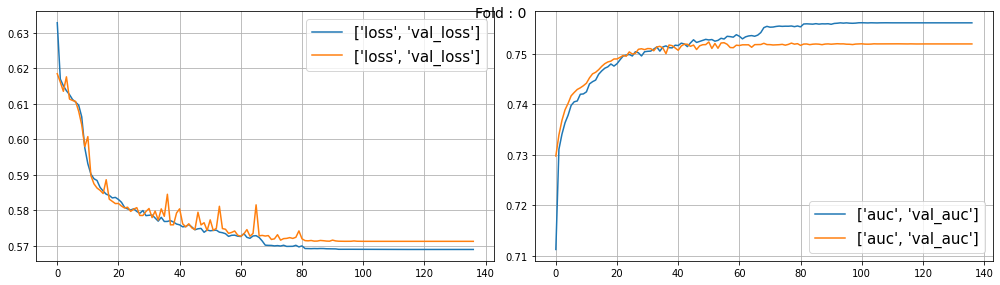

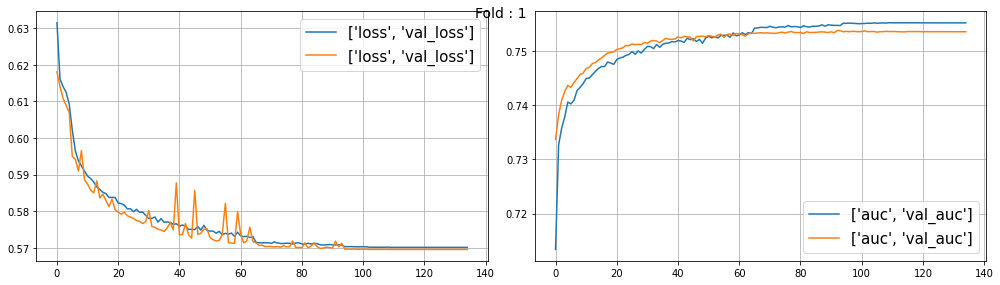

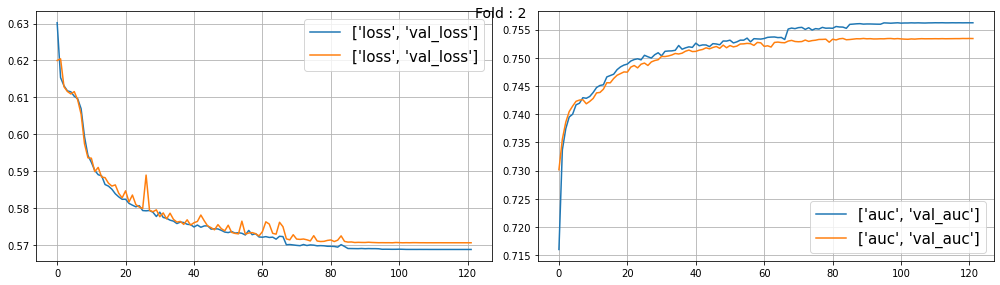

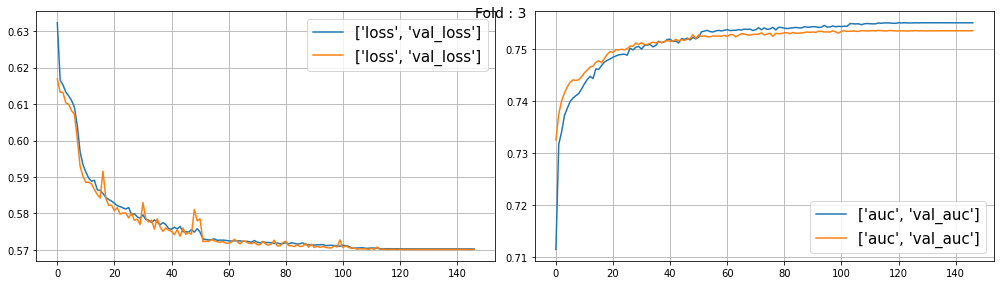

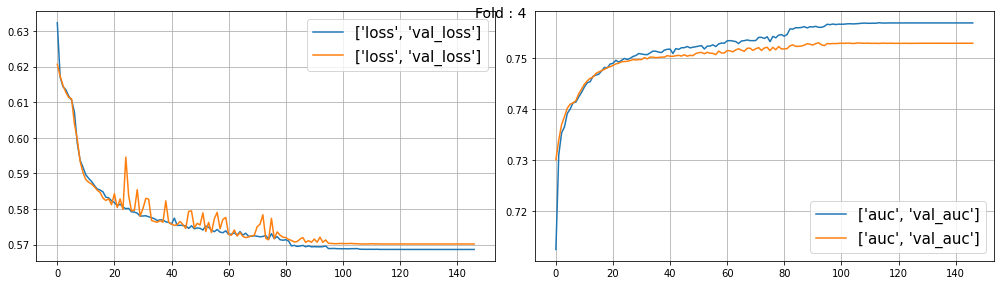

In [40]:
import matplotlib.pyplot as plt

for fold in range(f_scores['folds'].nunique()):
    history_f = f_scores[f_scores['folds'] == fold]

    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(14,4))
    fig.suptitle('Fold : '+str(fold), fontsize=14)
        
    plt.subplot(1,2,1)
    plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])
    plt.legend(fontsize=15)
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(history_f.loc[:, ['auc', 'val_auc']],label= ['auc', 'val_auc'])
    plt.legend(fontsize=15)
    plt.grid()
    
    print("Validation Loss: {:0.4f}".format(history_f['val_loss'].min()));

In [44]:


df_submission['target'] = np.mean(preds_test, axis = 0)
df_submission.to_csv('nn_3.csv', index=False)
df_submission.head()




,id,target
0,600000,0.732507
1,600001,0.745540
2,600002,0.760864
3,600003,0.453480
4,600004,0.729802


In [47]:
# Some parameters to config  https://www.kaggle.com/adityasharma01/simple-nn-tps-nov-21
EPOCHS        = 840
BATCH_SIZE    = 2048 * 2
ACTIVATION    = 'swish'
LEARNING_RATE = 0.000265713
FOLDS         = 5
name_model    = 'rnn_01_tunning'

feature_int      = X_test.filter(regex=r'f[0-9]').columns.to_list()
feature_cluster  = X_test.filter(regex=r'fe_clu').columns.to_list()
feature_static   = X_test.filter(regex=r'fe_[m-s]').columns.to_list()
feature_pipeline = make_pipeline(StandardScaler(),MinMaxScaler(feature_range=(0, 1)))

preprocessor = make_column_transformer((feature_pipeline, feature_int), 
                                      
                                       n_jobs=-1
                                      )

model, score, y_pred_test, df_score_history, _ = TunningModels.cross_valid(model_name_    = name_model,
                                                            X_train_       = train,
                                                            y_train_       = target,
                                                            X_test_        = test,
                                                            feature_       = None,
                                                            epochs_        = EPOCHS,
                                                            learning_rate_ = LEARNING_RATE,
                                                            batch_size_    = BATCH_SIZE,
                                                            activation_    = ACTIVATION,
                                                            fold_          = FOLDS,
                                                            target_        ='target',
                                                            path_          = path,
                                                            level_         = '1',
                                                            save_predict_  = True,
                                                            print_result_  = True,
                                                            seed_          = seed
                                                             ) 

Training model: Rede Neural TensorFlow - seed 12342 - Epoch: 840 - lr: 0.000265713 


ValueError: ignored